In [1]:
from model import UNet
from utils import *
from data import mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn
sampleRate = 68.27

## Train - Val - Test sets

In [2]:
train_path = "train"
val_path = "validation"
test_path = "test"
train_files = glob(os.path.join(train_path, '*.npy'))
val_files = glob(os.path.join(val_path, '*.npy'))
test_files = glob(os.path.join(test_path, '*.npy'))

In [3]:
for file in train_files:
    if file in val_files:
        print(f"{file} in validation dataset.")
    elif file in test_files:
        print(f"{file} in test set.")
    else:
        pass

## Hyperparameters

In [4]:
N_sub = 32
batch_size = 56
hidden_layers = 12
learning_rate = 0.01
num_epochs = 20

## Datasets and DataLoaders

In [5]:
train_dataset = mask_dataset(data_path='train', f_min = 1, f_max = 10, N_sub=N_sub,sampleRate=sampleRate)
train_loader = DataLoader(train_dataset,batch_size = batch_size,drop_last=True,shuffle = True)

In [6]:
val_dataset = mask_dataset(data_path='validation', f_min = 1, f_max = 10, N_sub=N_sub, sampleRate=sampleRate)
val_loader = DataLoader(val_dataset,batch_size = batch_size,drop_last=True,shuffle = True)

In [7]:
# test_dataset = maask_dataset(data_path='test', f_min = 1, f_max = 10, N_sub=N_sub, sampleRate=sampleRate)
# test_loader = DataLoader(test_dataset,batch_size = batch_size,drop_last=True,shuffle = True)

In [8]:
# GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

model = UNet(input_bands=1, output_classes=1,hidden_channels=hidden_layers)
model.to(device)

# Mean Square Error 
criterion = nn.MSELoss()

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

NVIDIA GeForce RTX 2070
device is cuda:0.


## Training

In [10]:
epochs_losses_train = []
epochs_losses_val = []
for epoch in range(num_epochs):
    print(f"Starting epoch: #{epoch}")
    batch_losses = []
        ## TRAIN ##
    for eval_samples, mask in tqdm(train_loader):
        # apply mask
        sample = eval_samples*mask.clone().detach()
        sample = torch.unsqueeze(sample.squeeze(), 1)
        
        # transfer to GPU
        eval_samples = eval_samples.to(device)
        sample = sample.to(device)
        optimizer.zero_grad()
        
        output = model(sample)
        loss = criterion(eval_samples.squeeze(),output.squeeze())
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epochs_losses_train.append(np.mean(batch_losses))
    model.eval()
    eval_losses = []
    with torch.no_grad():
        for eval_samples, mask in tqdm(val_loader):
            # apply mask
            sample = eval_samples*mask.clone().detach()
            sample = torch.unsqueeze(sample.squeeze(), 1)
            # transfer to GPU
            eval_samples = eval_samples.to(device)
            sample = sample.to(device)
            output = model(sample)
            loss = criterion(eval_samples.squeeze(), sample.squeeze())
            eval_losses.append(loss.item())
    epochs_losses_val.append(np.mean(eval_losses))
    model.train()

Starting epoch: #0


100%|██████████| 85/85 [00:19<00:00,  4.27it/s]


Starting epoch: #1


100%|██████████| 85/85 [00:20<00:00,  4.12it/s]


Starting epoch: #2


100%|██████████| 85/85 [00:14<00:00,  5.72it/s]


Starting epoch: #3


100%|██████████| 85/85 [00:15<00:00,  5.64it/s]


Starting epoch: #4


100%|██████████| 85/85 [00:21<00:00,  3.99it/s]


Starting epoch: #5


100%|██████████| 85/85 [00:16<00:00,  5.09it/s]


Starting epoch: #6


100%|██████████| 85/85 [00:20<00:00,  4.07it/s]


Starting epoch: #7


100%|██████████| 85/85 [00:18<00:00,  4.58it/s]


Starting epoch: #8


100%|██████████| 85/85 [00:42<00:00,  1.98it/s]


Starting epoch: #9


100%|██████████| 85/85 [01:38<00:00,  1.16s/it]


Text(0.5, 1.0, 'Validation MSE')

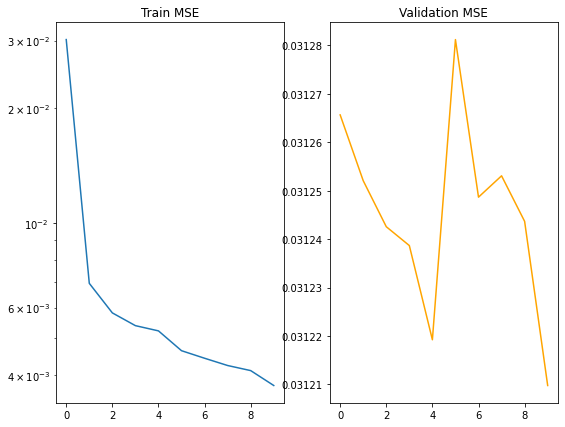

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (9,7))
ax1.plot(epochs_losses_train)
ax1.set_yscale("log")
ax1.set_title("Train MSE")
ax2.plot(epochs_losses_val,'orange')
ax2.set_title("Validation MSE")

In [12]:
torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, "C:\\Users\\nikos\\Desktop\\denoising\\model.pth")
